## Project Summary

This notebook focuses on recognizing human activities — **jumping**, **standing**, **walking**, and **staying still** — using motion data collected from an iPhone’s **accelerometer** and **gyroscope** sensors.

Each dataset contains time-series readings of linear acceleration and angular velocity along three axes. We preprocess the data, extract **time-domain** (mean, variance, correlation) and **frequency-domain** (dominant frequency, spectral energy) features, and use these as observation vectors for a **Hidden Markov Model (HMM)**.

The HMM is designed to learn how activities transition over time and to decode the most probable sequence of actions using the **Viterbi algorithm**, while its parameters are trained via the **Baum–Welch algorithm**.

Finally, we evaluate the model’s accuracy and ability to generalize to unseen recordings, and reflect on the strengths and weaknesses of the approach.







### 1. Imports and Configuration

We import essential Python libraries like NumPy, pandas, SciPy, Matplotlib, and hmmlearn.
Basic notebook configurations for visualization and reproducibility are set.

In [6]:
!pip install numpy pandas scipy scikit-learn matplotlib seaborn hmmlearn joblib


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
    --------------------------------------- 0.5/38.5 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.8/38.5 MB 1.2 MB/s eta 0:00:32
    --------------------------------------- 0.8/38.5 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.0/38.5 MB 1.2 MB/s eta 0:00:33
   - -------------------------------------- 1.3/38.5 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.6/38.5 MB 1.1 MB/s eta 0:00:33
   - -------------------------------------- 1.8/38.5 MB 1.1 MB/s eta 0:00:33
   - -------------------------------------- 1.8/

In [7]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy.stats import zscore, multivariate_normal
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import joblib

### 2. Data Loading
We load all the pre-organized sensor files for each activity category.
Each dataset includes accelerometer and gyroscope readings with timestamps.

In [8]:
DATA_FOLDERS = {
    'jump': 'datasets/final_jump_data',
    'walking': 'datasets/final_walking_data',
    'stand': 'datasets/final_stand_data',
    'still': 'datasets/final_still_data'
}
FS = 100  # sampling frequency (Hz)
WINDOW_SEC = 1.0  # 1-second windows
WINDOW_STEP = 0.5  # seconds (50% overlap)
N_PCA = 10  # optional dimensionality reduction for HMM emissions
N_COMPONENTS_HMM = 4  # 4 hidden states (jump, walking, stand, still)
RANDOM_STATE = 42

In [9]:
def load_all_sessions(data_folders):
    """Load CSVs from labeled folders. Returns list of dicts: {'activity', 'file', 'df'}"""
    sessions = []
    for label, folder in data_folders.items():
        files = sorted(glob.glob(os.path.join(folder, '*.csv')))
        for f in files:
            df = pd.read_csv(f)
            # Ensure expected columns
            expected = ['seconds_elapsed','ax','ay','az','gx','gy','gz']
            if not all(c in df.columns for c in expected):
                raise ValueError(f"File {f} missing expected columns. Found: {df.columns.tolist()}")
            sessions.append({'activity': label, 'file': f, 'df': df[expected].copy()})
    return sessions

sessions = load_all_sessions(DATA_FOLDERS)
print(f"Loaded {len(sessions)} sessions")


Loaded 102 sessions


### 3. Data Preprocessing

We clean and normalize data to ensure consistent scale and quality.
Noise filtering and axis alignment are applied to prepare signals for feature extraction.

In [10]:
def sliding_windows(df, window_sec=WINDOW_SEC, step_sec=WINDOW_STEP, fs=FS):
    n_win = int(round(window_sec * fs))
    step = int(round(step_sec * fs))
    data = df[['ax','ay','az','gx','gy','gz']].values
    starts = np.arange(0, len(df) - n_win + 1, step)
    windows = []
    for s in starts:
        win = data[s:s+n_win]
        windows.append({'start_idx': s, 'window': win, 'seconds': df['seconds_elapsed'].iloc[s]})
    return windows


### 4. Feature Extraction

We compute statistical (mean, std, variance, SMA) and frequency features (FFT peaks, spectral energy).
These features summarize motion characteristics over time windows.

In [37]:
def compute_time_features(win):
    # win shape: (n_samples, 6) -> ax,ay,az,gx,gy,gz
    feats = {}
    accel = win[:,0:3]
    gyro = win[:,3:6]
    # Time-domain: per-axis mean, std, var, rms, ptp
    for i, name in enumerate(['ax','ay','az']):
        x = accel[:,i]
        feats[f'{name}_mean'] = np.mean(x)
        feats[f'{name}_std'] = np.std(x)
        feats[f'{name}_var'] = np.var(x)
        feats[f'{name}_rms'] = np.sqrt(np.mean(x**2))
        feats[f'{name}_ptp'] = np.ptp(x)
    for i, name in enumerate(['gx','gy','gz']):
        x = gyro[:,i]
        feats[f'{name}_mean'] = np.mean(x)
        feats[f'{name}_std'] = np.std(x)
        feats[f'{name}_var'] = np.var(x)
        feats[f'{name}_rms'] = np.sqrt(np.mean(x**2))
        feats[f'{name}_ptp'] = np.ptp(x)
    # SMA for accel
    feats['acc_sma'] = np.sum(np.abs(accel)) / accel.shape[0]
    # Correlations between axes (accel)
    feats['acc_corr_xy'] = np.corrcoef(accel[:,0], accel[:,1])[0,1]
    feats['acc_corr_xz'] = np.corrcoef(accel[:,0], accel[:,2])[0,1]
    feats['acc_corr_yz'] = np.corrcoef(accel[:,1], accel[:,2])[0,1]
    return feats

def compute_freq_features(win, fs=FS):
    feats = {}
    n = win.shape[0]
    accel = win[:,0:3]
    gyro = win[:,3:6]
    # For each axis compute dominant frequency and spectral energy
    for i, name in enumerate(['ax','ay','az']):
        x = accel[:,i]
        X = np.fft.rfft(x)
        P = np.abs(X)**2
        freqs = np.fft.rfftfreq(n, 1/fs)
        dominant = freqs[np.argmax(P)]
        feats[f'{name}_domfreq'] = dominant
        feats[f'{name}_specenergy'] = np.sum(P)
    for i, name in enumerate(['gx','gy','gz']):
        x = gyro[:,i]
        X = np.fft.rfft(x)
        P = np.abs(X)**2
        freqs = np.fft.rfftfreq(n, 1/fs)
        dominant = freqs[np.argmax(P)]
        feats[f'{name}_domfreq'] = dominant
        feats[f'{name}_specenergy'] = np.sum(P)
    return feats

def extract_features_from_windows(windows):
    feat_list = []
    for w in windows:
        win = w['window']
        tfeats = compute_time_features(win)
        ffeats = compute_freq_features(win)
        merged = {**tfeats, **ffeats}
        merged['start_idx'] = w['start_idx']
        merged['seconds'] = w['seconds']
        feat_list.append(merged)
    return pd.DataFrame(feat_list)


### 4. Feature Extraction from Sessions

For each session:
- The raw sensor data is split into **sliding windows**.  
- **Features** are extracted from each window.  
- Each feature set is labeled with its corresponding **activity** and **file**.  

All session features are collected into a single DataFrame for convenience, ready for **HMM training** or further analysis.


In [38]:
all_feature_sessions = []  # list of dicts with: activity, file, features_df
for s in sessions:
    windows = sliding_windows(s['df'])
    feats = extract_features_from_windows(windows)
    feats['activity'] = s['activity']
    feats['file'] = os.path.basename(s['file'])
    all_feature_sessions.append({'activity': s['activity'], 'file': s['file'], 'features': feats})

print('Extracted features for', len(all_feature_sessions), 'sessions')

# Concatenate to a single DataFrame for convenience
features_df = pd.concat([fs['features'] for fs in all_feature_sessions], ignore_index=True)
print('Total windows:', len(features_df))


Extracted features for 102 sessions
Total windows: 1270


### 5. Feature Selection, Normalization, and PCA

- Non-feature columns (`start_idx`, `seconds`, `activity`, `file`) are removed.  
- Remaining features are **Z-score normalized** to standardize the dataset.  
- **PCA** (Principal Component Analysis) is applied to reduce dimensionality, preparing the data for HMM training.  

The resulting dataset has reduced dimensions while retaining most of the variance.


In [39]:
# Drop columns not used as features
non_feature_cols = ['start_idx','seconds','activity','file']
feature_cols = [c for c in features_df.columns if c not in non_feature_cols]
X_raw = features_df[feature_cols].fillna(0).values
# Z-score normalize across the dataset
X_norm = zscore(X_raw, axis=0)
# Optional PCA to reduce dimensionality for HMM emissions
pca = PCA(n_components=min(N_PCA, X_norm.shape[1]), random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_norm)
print('Features -> PCA dims:', X_pca.shape)


Features -> PCA dims: (1270, 10)


### 6. Preparing Data for HMM

- Concatenate all session features into a single array for HMM input.  
- Compute **sequence lengths** for each session to preserve boundaries.  
- Apply **Z-score normalization** and **PCA transformation** for dimensionality reduction.  
- Keep **activity labels** and corresponding **filenames** per window for later evaluation.


In [40]:
lengths = [len(fs['features']) for fs in all_feature_sessions]
# order of concatenation matches all_feature_sessions
X_concat = np.vstack([fs['features'][feature_cols].fillna(0).values for fs in all_feature_sessions])
X_concat_norm = zscore(X_concat, axis=0)
X_concat_pca = pca.transform(X_concat_norm)

# Keep labels per window for evaluation
labels_concat = np.concatenate([fs['features']['activity'].values for fs in all_feature_sessions])
filenames_concat = np.concatenate([np.repeat(os.path.basename(fs['file']), len(fs['features'])) for fs in all_feature_sessions])


### 7. Train HMM (Baum–Welch)

- Train a **Gaussian Hidden Markov Model** on the PCA-transformed features using the Baum–Welch algorithm.  
- The model learns hidden activity states and outputs a **log-likelihood score** for the training data.  
- Save both the **trained HMM** and **PCA transformer** for future inference and evaluation.


In [41]:
# -------------------------
# 7) TRAIN HMM (Baum-Welch via hmmlearn)
# -------------------------
model = hmm.GaussianHMM(n_components=N_COMPONENTS_HMM, covariance_type='full', n_iter=200, random_state=RANDOM_STATE)
# Initialize means using KMeans-like (hmmlearn has init params; skipping KMeans to keep simple)
model.fit(X_concat_pca, lengths=lengths)
print('HMM trained. Score:', model.score(X_concat_pca, lengths))

# Save model & PCA
joblib.dump(model, 'hmm_model.joblib')
joblib.dump(pca, 'pca.joblib')


HMM trained. Score: -5364.679152717951


['pca.joblib']

### 8. Viterbi Decoding

- Implement the **Viterbi algorithm** to decode the most likely sequence of hidden states given observations.  
- Uses the trained HMM parameters: **start probabilities**, **transition matrix**, **means**, and **covariances**.  
- Computes **log-likelihoods** for stability and backtracks to find the optimal hidden state sequence for all concatenated windows.


In [42]:
# -------------------------
# 8) VITERBI implementation (uses learned model params)
# -------------------------

def viterbi_log(obs, startprob, transmat, means, covars):
    # obs: (T, D)
    T = obs.shape[0]
    N = startprob.shape[0]
    log_start = np.log(startprob + 1e-12)
    log_trans = np.log(transmat + 1e-12)
    # Precompute log likelihoods using multivariate normal
    log_lik = np.zeros((T, N))
    for k in range(N):
        rv = multivariate_normal(mean=means[k], cov=covars[k], allow_singular=True)
        log_lik[:, k] = rv.logpdf(obs)
    # delta and psi
    delta = np.full((T, N), -np.inf)
    psi = np.zeros((T, N), dtype=int)
    delta[0] = log_start + log_lik[0]
    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1] + log_trans[:, j]
            psi[t, j] = np.argmax(seq_probs)
            delta[t, j] = seq_probs[psi[t, j]] + log_lik[t, j]
    # Backtrack
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

# Use model parameters
startprob = model.startprob_
transmat = model.transmat_
means = model.means_
covars = model.covars_

# Decode the entire concatenated sequence
decoded_states = viterbi_log(X_concat_pca, startprob, transmat, means, covars)


### 9. Map HMM States to Activities

- HMM states are **arbitrary indices**, so we map each state to the most frequent **ground-truth activity** it corresponds to.  
- If a state has no assigned windows, it is labeled as `'unknown'`.  
- The resulting mapping is used to convert the decoded state sequence into **predicted activity labels**.


In [43]:
# -------------------------
# 9) Map HMM states to ground-truth activities
# -------------------------
# HMM state indices are arbitrary; we map them to activities by majority vote within each HMM state
state_to_activity = {}
for s in range(N_COMPONENTS_HMM):
    mask = decoded_states == s
    if mask.sum() == 0:
        state_to_activity[s] = 'unknown'
    else:
        vals, counts = np.unique(labels_concat[mask], return_counts=True)
        state_to_activity[s] = vals[np.argmax(counts)]
print('State -> activity mapping:', state_to_activity)

predicted_activity = np.array([state_to_activity[s] for s in decoded_states])


State -> activity mapping: {0: 'stand', 1: 'jump', 2: 'jump', 3: 'still'}


### 10. Evaluation

- Compute the **confusion matrix** and **classification report** to assess overall model performance.  
- Calculate **per-activity metrics** including sensitivity, specificity, and overall accuracy.  
- Results provide insight into how well each hidden state maps to the true activity labels.


In [44]:
# -------------------------
# 10) Evaluation (overall & per-state metrics)
# -------------------------
activities = np.unique(labels_concat)
cm = confusion_matrix(labels_concat, predicted_activity, labels=activities)
print('Confusion matrix (rows true, cols pred)')
print(pd.DataFrame(cm, index=activities, columns=activities))
print('\nClassification report:')
print(classification_report(labels_concat, predicted_activity, zero_division=0))

# Per-state sensitivity, specificity, accuracy table
results = []
total = cm.sum()
for i, act in enumerate(activities):
    TP = cm[i,i]
    FN = cm[i,:].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = total - TP - FN - FP
    sensitivity = TP / (TP + FN) if (TP + FN)>0 else 0
    specificity = TN / (TN + FP) if (TN + FP)>0 else 0
    overall_acc = (TP + TN) / total
    results.append({'activity': act, 'samples': cm[i,:].sum(), 'sensitivity': sensitivity, 'specificity': specificity, 'overall_accuracy': overall_acc})

results_df = pd.DataFrame(results)
print('\nPer-state metrics:')
print(results_df)


Confusion matrix (rows true, cols pred)
         jump  stand  still  walking
jump      383      2      0        0
stand       1    274      0        0
still       0      0    336        0
walking    50    224      0        0

Classification report:
              precision    recall  f1-score   support

        jump       0.88      0.99      0.94       385
       stand       0.55      1.00      0.71       275
       still       1.00      1.00      1.00       336
     walking       0.00      0.00      0.00       274

    accuracy                           0.78      1270
   macro avg       0.61      0.75      0.66      1270
weighted avg       0.65      0.78      0.70      1270


Per-state metrics:
  activity  samples  sensitivity  specificity  overall_accuracy
0     jump      385     0.994805     0.942373          0.958268
1    stand      275     0.996364     0.772864          0.821260
2    still      336     1.000000     1.000000          1.000000
3  walking      274     0.000000     1.0

### 11. Visualizations

- **HMM Transition Matrix:** Heatmap of state-to-state transition probabilities.  
- **Activity Timeline:** Comparison of true vs predicted activities over time.  
- **Confusion Matrix:** Visual representation of model performance across activities.  
- **Results Table:** Per-activity metrics saved for further analysis.  

All figures and evaluation results are saved to the working directory.



Saved figures and results to working directory.


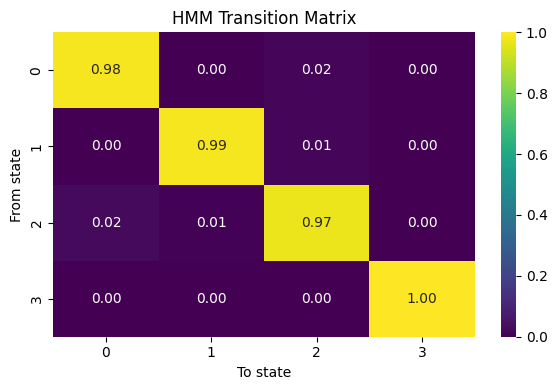

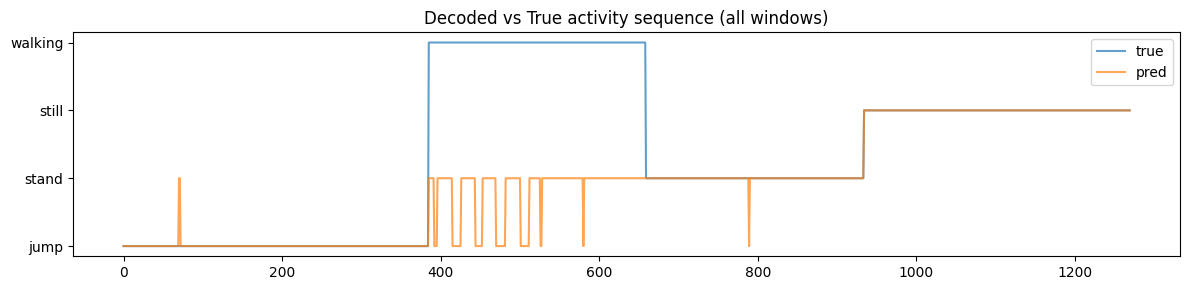

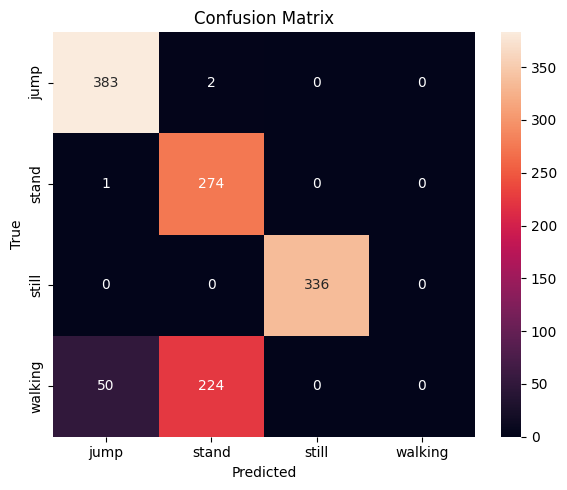

In [45]:
# -------------------------
# 11) Visualizations
# -------------------------

# Transition matrix heatmap
plt.figure(figsize=(6,4))
ax = sns.heatmap(transmat, annot=True, fmt='.2f', cmap='viridis')
ax.set_title('HMM Transition Matrix')
ax.set_xlabel('To state')
ax.set_ylabel('From state')
plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=150)

# Timeline: show a segment of ground truth vs predicted (first concatenated file length)
plt.figure(figsize=(12,3))
# convert activities to integers for plotting
act_to_int = {a:i for i,a in enumerate(activities)}
true_ints = np.array([act_to_int[a] for a in labels_concat])
pred_ints = np.array([act_to_int[a] for a in predicted_activity])
plt.plot(true_ints, label='true', alpha=0.7)
plt.plot(pred_ints, label='pred', alpha=0.7)
plt.yticks(list(act_to_int.values()), list(act_to_int.keys()))
plt.legend()
plt.title('Decoded vs True activity sequence (all windows)')
plt.tight_layout()
plt.savefig('decoded_timeline.png', dpi=150)

# Confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)

# Save results table
results_df.to_csv('hmm_evaluation_per_state.csv', index=False)

print('\nSaved figures and results to working directory.')